# Importing libraries

In [74]:
%load_ext autoreload
%autoreload 2

In [75]:
import math
import random
import time
from math import exp
import os, os.path

In [76]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
from numpy import *
from sklearn import datasets, linear_model
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer

In [77]:
from Bayesneuralnet_regcls import MCMC, Network, scikit_linear_mod

In [78]:
def safe_open_w(path):
    ''' Open "path" for writing, creating any parent directories as needed.
    '''
    os.makedirs(os.path.dirname(path), exist_ok=True)
    return open(path, 'w')

# Setting model parameters and datasets

In [79]:
w_limit =  0.025 # step size for w
tau_limit = 0.2 # step size for eta
save_weight = False


problem = 1

if problem == 1:
    # Lazer
    traindata = np.loadtxt("data/Lazer/train.txt")
    testdata = np.loadtxt("data/Lazer/test.txt")  #
    name = "Lazer"
    hidden = 5
    input = 4  
    output = 1
    prob_type = 'regression'
elif problem == 2:
    # Sunspot
    traindata = np.loadtxt("data/Sunspot/train.txt")
    testdata = np.loadtxt("data/Sunspot/test.txt")  #
    name = "Sunspot"
    hidden = 5
    input = 4  #
    output = 1
    prob_type = 'regression' 
elif problem == 3:
    # Iris
    data  = np.genfromtxt('data/iris.csv',delimiter=';')
    classes = data[:,4].reshape(data.shape[0],1)-1
    features = data[:,0:4]#Normalizing Data

    name = "Iris"
    hidden = 12
    input = 4 #input
    output = 3

    for k in range(input):
        mean = np.mean(features[:,k])
        dev = np.std(features[:,k])
        features[:,k] = (features[:,k]-mean)/dev
        train_ratio = 0.7 #choose
        indices = np.random.permutation(features.shape[0])
        traindata = np.hstack([features[indices[:np.int(train_ratio*features.shape[0])],:],classes[indices[:np.int(train_ratio*features.shape[0])],:]])
        testdata = np.hstack([features[indices[np.int(train_ratio*features.shape[0])]:,:],classes[indices[np.int(train_ratio*features.shape[0])]:,:]])
        prob_type = 'classification'
elif problem == 4:
    # Ionosphere
    traindata = np.genfromtxt('data/ionesphere/ftrain.csv',delimiter=',')[:,:-1]
    testdata = np.genfromtxt('data/ionesphere/ftest.csv',delimiter=',')[:,:-1]
    name = "Ionosphere"
    hidden = 50 # larger network, so a smaller sample size may be used
    input = 34 #input
    output = 2
    prob_type = 'classification'

In [60]:
print(traindata.shape)
print('--------------------------')
print(testdata.shape)

(245, 35)
--------------------------
(109, 35)


# Training the model

In [80]:
# Bayesian neural network

topology = [input, hidden, output] 

numSamples = 50000 # need to decide yourself
use_langevin_gradients  = True
l_prob = 0.5
learn_rate = 0.01
train_times = 1

for i in range(train_times):
    timer = time.time() 
    mcmc = MCMC( use_langevin_gradients , l_prob,  learn_rate, numSamples, traindata, testdata, topology, prob_type)  # declare class


    [pos_w, pos_tau, fx_train, fx_test, x_train, x_test, p_train, p_test, accept_ratio] = mcmc.sampler(w_limit, tau_limit)
    print('sucessfully sampled')

    burnin = 0.5 * numSamples  # use post burn in samples

    timer2 = time.time()

    timetotal = (timer2 - timer) /60
    print((timetotal), 'min taken')

    pos_w = pos_w[int(burnin):, ]
    pos_tau = pos_tau[int(burnin):, ]

    fx_mu = fx_test[int(burnin):,].mean(axis=0)
    fx_high = np.percentile(fx_test[int(burnin):,], 95, axis=0)
    fx_low = np.percentile(fx_test[int(burnin):,], 5, axis=0)

    fx_mu_tr = fx_train[int(burnin):,].mean(axis=0)
    fx_high_tr = np.percentile(fx_train[int(burnin):,], 95, axis=0)
    fx_low_tr = np.percentile(fx_train[int(burnin):,], 5, axis=0)

    pos_w_mean = pos_w.mean(axis=0) 

    p_tr = np.mean(p_train[int(burnin):])
    ptr_std = np.std(p_train[int(burnin):])
    p_tes = np.mean(p_test[int(burnin):])
    ptest_std = np.std(p_test[int(burnin):])
    print(p_tr, ptr_std, p_tes, ptest_std)
    
    if save_weight:
        np.savetxt('result/' + name + '/pos_w_' + str(i) + '.txt', pos_w)

# outres_db = open('result.txt', "a+")
# np.savetxt(outres_db, ( use_langevin_gradients, learn_rate, p_tr, ptr_std, p_tes, ptest_std, accept_ratio, timetotal), fmt='%1.5f')


    ytestdata = testdata[:, input]
    ytraindata = traindata[:, input]
    
    
    if prob_type == 'regression':
        print('---RMSE train---')
        print('mean', mcmc.rmse(ytraindata, fx_mu_tr))
        print('high', mcmc.rmse(ytraindata, fx_high_tr))
        print('low', mcmc.rmse(ytraindata, fx_low_tr))
        print('---RMSE test---')
        print('mean', mcmc.rmse(ytestdata, fx_mu))
        print('high', mcmc.rmse(ytestdata, fx_high))
        print('low', mcmc.rmse(ytestdata, fx_low))
    else:
        print('---accuracy train---')
        print('mean', mcmc.accuracy(ytraindata, fx_mu_tr))
        print('high', mcmc.accuracy(ytraindata, fx_high_tr))
        print('low', mcmc.accuracy(ytraindata, fx_low_tr))
        print('---accuracy test---')
        print('mean', mcmc.accuracy(ytestdata, fx_mu))
        print('high', mcmc.accuracy(ytestdata, fx_high))
        print('low', mcmc.accuracy(ytestdata, fx_low)) 

y_train size:  298
y_test size:  198
evaluate Initial w
-40.70424197580428  Initial likelihood
0 -28.50784371950047 -40.936415387998885 0 0.2607583248045319 0.19847076485706938 accepted
50 35.115085673962426 -40.70485576509585 -0.005366416165419441 0.21452906237160677 0.13748395409144223 accepted
100 39.560221703727564 -40.90316938398454 -0.013349171695030915 0.2111340773692604 0.13479892722076764 accepted
150 47.272061603319884 -40.68522995905913 0 0.20641954604469726 0.13180305610558482 accepted
600 169.1479796699987 -40.15929998744294 0.0033034860258867593 0.1367463573628441 0.088049390580547 accepted
650 189.6035926038135 -40.031439924533466 0 0.1269198787402367 0.08184990449291717 accepted
700 201.16723305829711 -40.18624750836818 -0.03690052825173262 0.12319336553054609 0.08005779284505647 accepted
850 233.9893607931364 -40.104530688685955 0 0.11026480625228793 0.07986898098577029 accepted
1100 254.00549511451393 -40.30492817874111 -0.004793916783450314 0.10291058107895219 0.0786

Checking the RMSE or accuracy of model.

In [81]:
if prob_type == 'regression':
    print('---RMSE train---')
    print('mean', mcmc.rmse(ytraindata, fx_mu_tr))
    print('high', mcmc.rmse(ytraindata, fx_high_tr))
    print('low', mcmc.rmse(ytraindata, fx_low_tr))
    print('---RMSE test---')
    print('mean', mcmc.rmse(ytestdata, fx_mu))
    print('high', mcmc.rmse(ytestdata, fx_high))
    print('low', mcmc.rmse(ytestdata, fx_low))
    
    with safe_open_w('result/' + name + "/results.txt") as f:
        f.write("RMSE train (mean, high, low) : ")
        f.write(str(mcmc.rmse(ytraindata, fx_mu_tr)) + ', ')
        f.write(str(mcmc.rmse(ytraindata, fx_high_tr)) + ', ')
        f.write(str(mcmc.rmse(ytraindata, fx_low_tr)) + '\n')
        
        f.write("RMSE test (mean, high, low) : ")
        f.write(str(mcmc.rmse(ytestdata, fx_mu)) + ' , ')
        f.write(str(mcmc.rmse(ytestdata, fx_high)) + ' , ')
        f.write(str(mcmc.rmse(ytestdata, fx_low)) + '\n')
        f.close()
else:
    print('---accuracy train---')
    print('mean', mcmc.accuracy(ytraindata, fx_mu_tr))
    print('high', mcmc.accuracy(ytraindata, fx_high_tr))
    print('low', mcmc.accuracy(ytraindata, fx_low_tr))
    print('---accuracy test---')
    print('mean', mcmc.accuracy(ytestdata, fx_mu))
    print('high', mcmc.accuracy(ytestdata, fx_high))
    print('low', mcmc.accuracy(ytestdata, fx_low)) 
    
    with safe_open_w('result/' + name + "/results.txt") as f:
        f.write("Accuracy train: ")
        f.write(str(mcmc.accuracy(ytraindata, fx_mu_tr)) + ', ')
        
        f.write("Accuracy test: ")
        f.write(str(mcmc.accuracy(ytestdata, fx_mu)) + ' , ')
        f.close()

---RMSE train---
mean 0.021494763372190365
high 0.022540406624517374
low 0.02196976732779881
---RMSE test---
mean 0.02288446274462423
high 0.024260837216766088
low 0.023024868351060795


# Visualising the results

## Training set

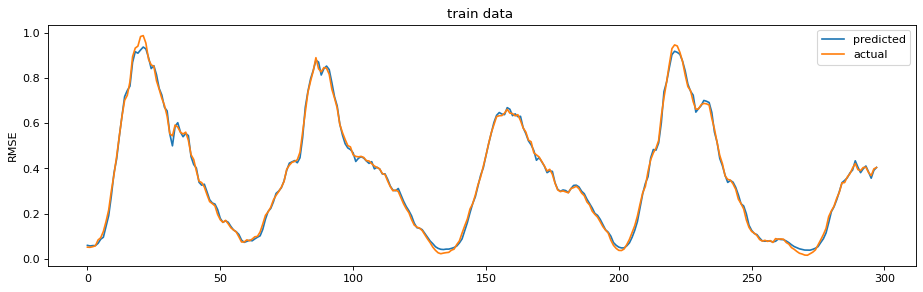

<Figure size 432x288 with 0 Axes>

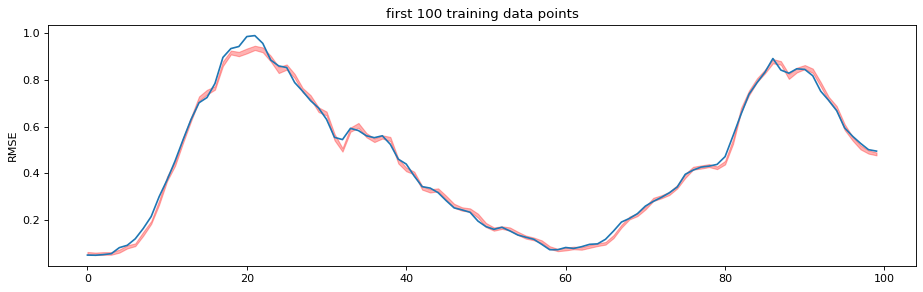

<Figure size 432x288 with 0 Axes>

In [48]:
figure(figsize=(14, 4), dpi=80)
plt.title("train data ")
plt.plot(range(fx_mu_tr.shape[0]) , fx_mu_tr, label = "predicted")
plt.plot(range(ytraindata.shape[0])  , ytraindata, label = "actual")
plt.ylabel("RMSE")
plt.legend()
plt.savefig("result/" + name + "/train_result")
plt.show()
plt.clf()

figure(figsize=(14, 4), dpi=80)
plt.title("first 100 training data points")
plt.plot(range(100) , ytraindata[:100])
plt.ylabel("RMSE")
plt.fill_between(range(100), np.maximum.reduce(fx_train[int(burnin):,])[:100], np.minimum.reduce(fx_train[int(burnin):,])[:100], alpha=0.3, color='red')
plt.savefig("result/" + name + "/train_result_first100")
plt.show()
plt.clf()




## Testing set

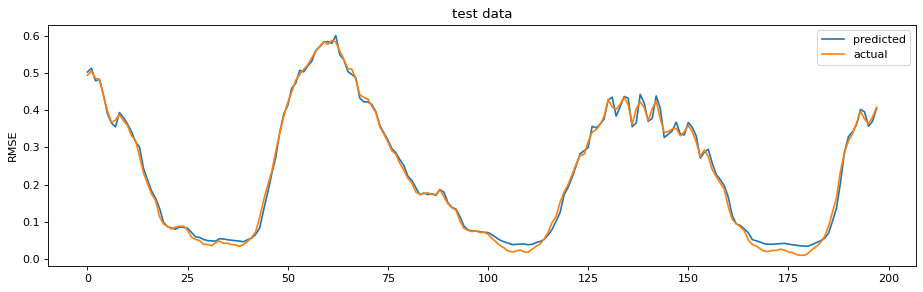

<Figure size 432x288 with 0 Axes>

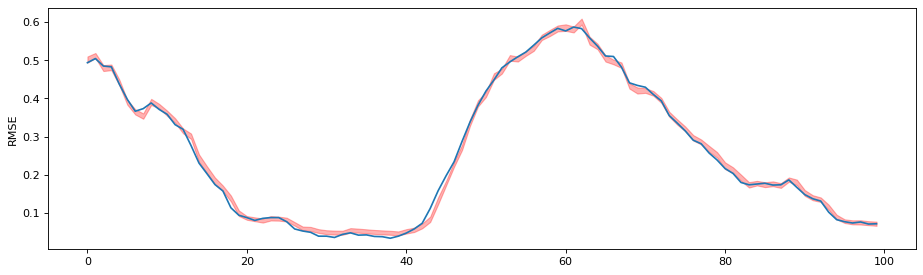

<Figure size 432x288 with 0 Axes>

In [49]:
figure(figsize=(14, 4), dpi=80)
plt.title("test data")
plt.plot(range(fx_test.shape[1]) , fx_mu, label = "predicted")
plt.plot(range(fx_test.shape[1]) , ytestdata, label = "actual")
plt.legend()
plt.ylabel("RMSE")
plt.savefig("result/" + name + "/test_result")
plt.show()
plt.clf()

figure(figsize=(14, 4), dpi=80)
plt.plot(range(100) , ytestdata[:100])
plt.fill_between(range(100), np.maximum.reduce(fx_test[int(burnin):,])[:100], np.minimum.reduce(fx_test[int(burnin):,])[:100], alpha=0.3, color='red')
plt.ylabel("RMSE")
plt.savefig("result/" + name + "/test_result_first100")
plt.show()
plt.clf()


## Trace plots for posterior weights

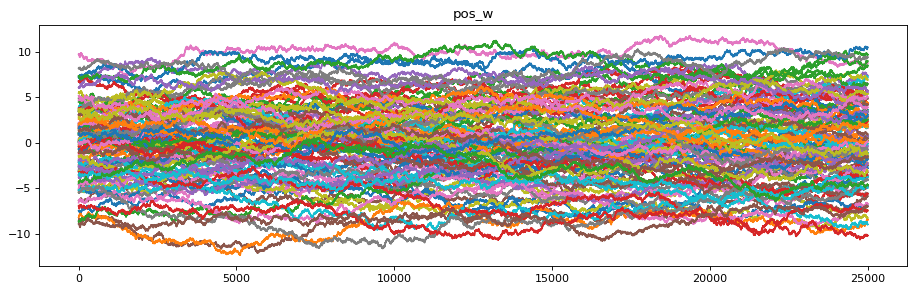

<Figure size 432x288 with 0 Axes>

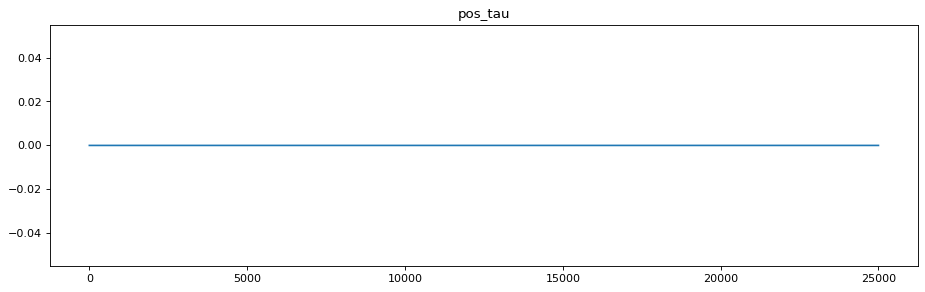

<Figure size 432x288 with 0 Axes>

In [70]:
figure(figsize=(14, 4), dpi=80)
plt.title("pos_w")
for i in range(pos_w.shape[1]):
    plt.plot(range(int(burnin)) , pos_w[:, i])
plt.savefig("result/" + name + "/trace_plot_w")
plt.show()
plt.clf()

figure(figsize=(14, 4), dpi=80)
plt.title("pos_tau")
plt.plot(range(int(burnin)), pos_tau[:, 0])
plt.savefig("result/" + name + "/trace_plot_tau")
plt.show()
plt.clf()


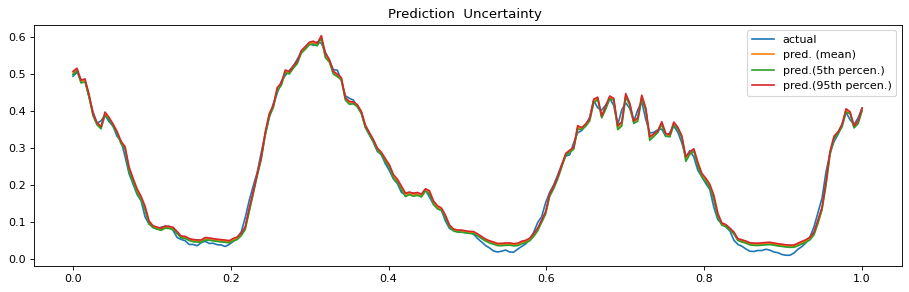

<Figure size 432x288 with 0 Axes>

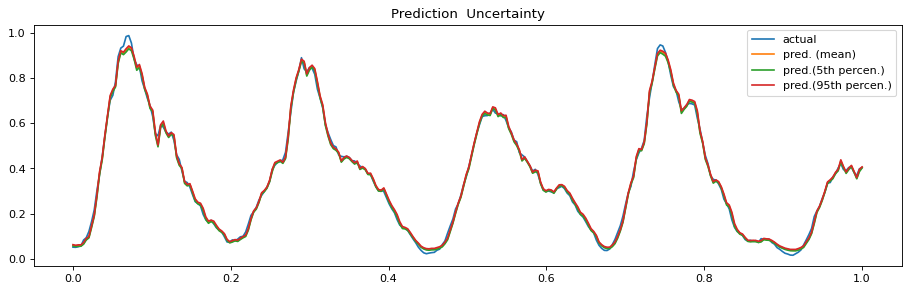

<Figure size 432x288 with 0 Axes>

In [51]:
if prob_type == 'regression':
    
    figure(figsize=(14, 4), dpi=80)
    
    plt.plot(x_test, ytestdata, label='actual')
    plt.plot(x_test, fx_mu, label='pred. (mean)')    
    
    plt.plot(x_test, fx_low, label='pred.(5th percen.)')
    plt.plot(x_test, fx_high, label='pred.(95th percen.)')
    plt.fill_between(x_test, fx_low, fx_high, facecolor='g', alpha=0.4)
    plt.legend(loc='upper right')

    plt.title("Prediction  Uncertainty ")
    plt.show()
#         plt.savefig('mcmcrestest.png') 
    plt.clf()
    
    # -----------------------------------------
    figure(figsize=(14, 4), dpi=80)
    plt.plot(x_train, ytraindata, label='actual')
    plt.plot(x_train, fx_mu_tr, label='pred. (mean)')
    plt.plot(x_train, fx_low_tr, label='pred.(5th percen.)')
    plt.plot(x_train, fx_high_tr, label='pred.(95th percen.)')
    plt.fill_between(x_train, fx_low_tr, fx_high_tr, facecolor='g', alpha=0.4)
    plt.legend(loc='upper right')

    plt.title("Prediction  Uncertainty")
    plt.show()
#         plt.savefig('mcmcrestrain.png') 
    plt.clf()


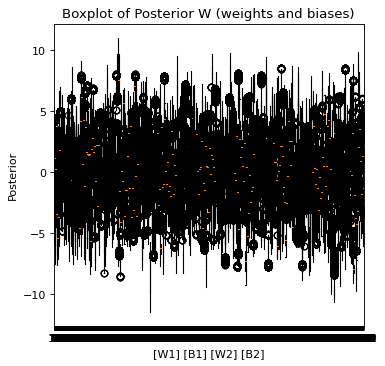

<Figure size 432x288 with 0 Axes>

In [65]:

mpl_fig = plt.figure(figsize=(5,5), dpi=80)
ax = mpl_fig.add_subplot(111)

ax.boxplot(pos_w)
ax.set_xlabel('[W1] [B1] [W2] [B2]')
ax.set_ylabel('Posterior')
#         plt.legend(loc='upper right')
plt.title("Boxplot of Posterior W (weights and biases)")
plt.savefig("result/" + name + "/pos_w_boxplot")
plt.show()

plt.clf()